In [8]:
import tensorflow as tf 
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import rcParams

tf.keras.config.set_floatx('float64')

#tf.config.run_functions_eagerly(True)

# Define the number of neuron per layer
NN = 10
#Define the number of layers 
NL = 5
#Define number of collocation points
N_points = 87
#
N_test = 50 # per time step
# Define the number of epochs
N_epoch = 1000

# # Define the manufactured solution
# def u_sol(x, t):
#     return tf.exp(-t) * tf.sin(x)

# # Compute the time derivative of u (u_t)
# def u_t(x, t):
#     return -tf.exp(-t) * tf.sin(x)

# # Compute the Laplacian of u (u_xx) in one dimension
# def u_xx(x, t):
#     return -tf.exp(-t) * tf.sin(x)

# Compute the source term f(x, t) = u_t - u_xx
def f_source(x,t):
    return -tf.exp(t)*tf.sin(x)*(np.pi**2-1)

def U_init(x):
    return tf.sin(x)

## Time discretization
delta_t = 0.1
t_steps = 10

#Input dummy
X = tf.keras.layers.Input(shape = (1,))

#Define the first layer with dummy input
L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(X)

#Feed the first layer to a generic layer for the number of layers, without the first and last layers
for l in range(NL - 2):
    L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(L1)

#Last layer after being fed with the second to last layer (1 output)
L_last = tf.keras.layers.Dense(units=t_steps, activation = 'tanh',dtype='float64')(L1)

#Assembly the model
U_model = tf.keras.Model(inputs = X, outputs = L_last, name = 'U_model')

#model summary
U_model.summary()


Model: "U_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460 (3.59 KB)

 Trainable params: 460 (3.59 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Define a class for the loss, we are going to call this class in every iteration, 
# evaluating this on the randomized sample, the target function and the output 
# of the network
###############################################################################
#Parameters for the class "loss": U_model --> Neural Network Architecture     #
#           N_points --> Number of Sampled points across the problem's domain #
#           f_source --> Source function on the PDE -Δu = f                   #
###############################################################################
class loss(tf.keras.layers.Layer):

    def __init__(self, U_model, N_points,f_source,N_test,t_steps,U_init,delta_t, **kwargs):
        super(loss,self).__init__()
        self.U_model = U_model
        self.N_points = N_points
        self.f_source = f_source
        self.N_test = N_test
        self.t_steps = t_steps
        self.U_init = U_init
        self.dt = delta_t

    #Compute the derivative of the neural network U_nn
    def  call(self,input):
        
        #Get a sample of points in the domain for the integration. 
        N_pointsreal = random.randint(self.N_points-1, self.N_points)
        
        S = tf.experimental.numpy.linspace(0.,np.pi,num=N_pointsreal, dtype='float64')
       
        with tf.GradientTape(persistent=True) as t1:       
            t1.watch(S)
            # Ojo: la salida de esto tf.transpose(U_model(xlist)) es tf.Tensor: shape=(tiempos,espacio)
            ueval = tf.transpose(self.U_model(S)) # (tiempos,espacio)

            loss_out = 0
            for t in range(self.t_steps):
              
                #Compute a vector of the source function evaluated in the sample points & 
                F = self.f_source(S,tf.constant(t*self.dt,dtype=tf.float64))

                # Arma las funciones de base que usamos en la integral de la fuente
                G = tf.experimental.numpy.asarray([(1/i)*(np.sqrt(2)/np.pi)*tf.math.sin(i*S) 
                                                   for i in range(1,self.N_test)],dtype='float64')
        
                if t == 0:
                    U0 = self.U_init(S)
                    Integral_source = tf.einsum('i,ki->k',U0,G)
                else:
                    Integral_source = tf.einsum('i,ki->k',F+ueval[t-1],G)

                # Arma el gradiente de las funciones de base que usamos en la integral maluca
                H = tf.experimental.numpy.asarray([(np.sqrt(2)/np.pi)*tf.cos(i*S) 
                                                   for i in range(1,self.N_test)],dtype='float64')
            
                u_x_tn = t1.gradient(ueval[t],S)
                
                Integral_Unn = tf.einsum('i,ki->k',u_x_tn,H)

                Integral_nueva = tf.einsum('i,ki->k',ueval[t],G)

                loss_out += tf.reduce_sum((Integral_nueva + self.dt*Integral_Unn - Integral_source)**2)
        
        del t1

        loss_total = 0.7*loss_out #+ 0.3(self.U_model(np.array([0.]))**2 + self.U_model(np.array([1.]))**2)
        return loss_total


#Tell tensorlofw to recognize this class as a loss
def loss_model(U_model,N_points, f_source,N_test,t_steps,U_init,dt):
    Xl = tf.keras.layers.Input(shape = (1,),dtype='float64')
    loss_layer = loss(U_model, N_points, f_source,N_test,t_steps,U_init,dt)(Xl)
    loss_f = tf.keras.Model(inputs = Xl, outputs = loss_layer)
    return loss_f

def loss_value(x,y):
    return y

#Assemble the model
model_all = loss_model(U_model,N_points,f_source,N_test,t_steps,U_init,delta_t)
optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-3)
model_all.compile(optimizer = optimizer, loss = loss_value)

#Train the model
history = model_all.fit(np.array([1.]),np.array([1.]),epochs = N_epoch)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 565765.8125
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 565270.1875
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 564772.2500
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 564272.8125
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 563772.7500
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 563272.8125
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 562773.8750
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 562276.7500
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 561782.0000
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 561290.3125
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 560802.3125
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 560318.3750
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 559838.8125
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 559364.0625
Epo

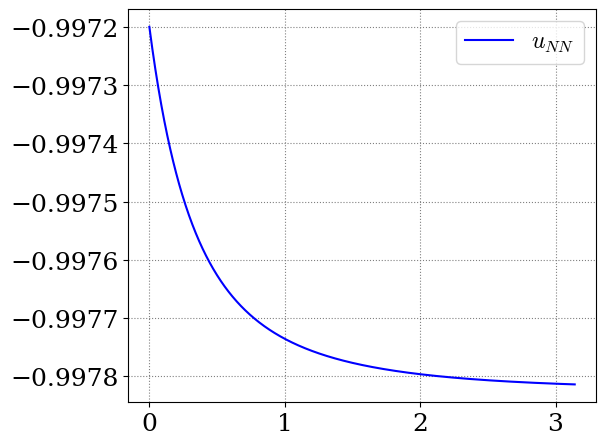

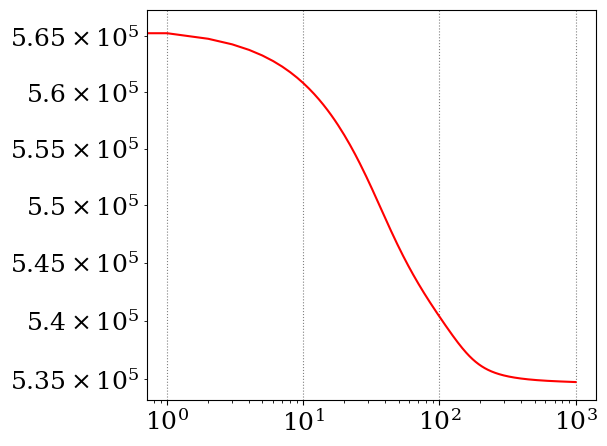

In [ ]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 17
rcParams['mathtext.fontset'] = 'cm' 
rcParams['axes.labelsize'] = 19


# Generate a list of x values for visualization
xlist = tf.experimental.numpy.linspace(0.,np.pi,num=1000, dtype='float32')

## ---------
# Graph the Solution
## ---------

fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(xlist, U_model(xlist)[:,-1], color='b')
#plt.plot(xlist, uexact(xlist), color='m')

plt.legend(['$u_{NN}$', '$u$'])

ax.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.title('Solucion')
plt.show()


Loss_rel = history.history['loss'] 
fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(Loss_rel, color='r')


ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(which = 'major', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()



<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([-0.99719979, -0.99720539, -0.99721092, -0.99721638, -0.99722178,
       -0.99722711, -0.99723238, -0.99723758, -0.99724273, -0.99724781,
       -0.99725283, -0.99725779, -0.99726269, -0.99726753, -0.99727231,
       -0.99727704, -0.99728172, -0.99728634, -0.9972909 , -0.99729542,
       -0.99729988, -0.99730429, -0.99730864, -0.99731295, -0.99731721,
       -0.99732142, -0.99732559, -0.9973297 , -0.99733377, -0.9973378 ,
       -0.99734178, -0.99734571, -0.9973496 , -0.99735345, -0.99735725,
       -0.99736102, -0.99736474, -0.99736842, -0.99737206, -0.99737566,
       -0.99737922, -0.99738274, -0.99738623, -0.99738967, -0.99739308,
       -0.99739646, -0.99739979, -0.9974031 , -0.99740636, -0.99740959,
       -0.99741279, -0.99741596, -0.99741909, -0.99742219, -0.99742525,
       -0.99742828, -0.99743129, -0.99743426, -0.9974372 , -0.99744011,
       -0.99744299, -0.99744584, -0.99744866, -0.99745145, -0.99745422,
       -0.99745